In [146]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import tensor
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib as mpl
from datasets import load_dataset
from torch.utils.data import DataLoader, default_collate
from operator import itemgetter, attrgetter
mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [9]:
name = 'fashion_mnist'
x,y = 'image', 'label'
rds = load_dataset(name)

Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [339]:
def get_dls(train_ds, valid_ds, batch_size, **kwargs):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs),
        DataLoader(train_ds, batch_size=batch_size*2, shuffle=True, **kwargs)
    )

def collate_dict(d):
    g = itemgetter(*d.features)
    def _f(b):
        return g(default_collate(b))
    return _f

class DataLoaders:
    def __init__(self, *dls):
        self.train_dl,self.val_dl = dls[:2]
    
    @classmethod
    def from_dd(cls, ds, batch_size, **kwargs):
        f = collate_dict(ds['train'])
        return cls(*get_dls(*ds.values(), batch_size=batch_size, collate_fn=f, **kwargs))

In [340]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

@inplace
def transform_(b):
    x,y = 'image', 'label'
    b[x] = [torch.flatten(TF.to_tensor(ele)) for ele in b[x]]

In [341]:
tds = rds.with_transform(transform_)

In [342]:
bs = 1024
dls = DataLoaders.from_dd(tds, batch_size=bs)

In [343]:
class CancelFitException(Exception):
    pass
class CancelBatchException(Exception):
    pass
class CancelEpochException(Exception):
    pass

In [344]:
class Callback():
    order = 0

In [383]:
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None:
            method(learn)

In [384]:
n,nh = 28*28,50

def get_model():
    return nn.Sequential(*[
        nn.Linear(n, nh),
        nn.ReLU(),
        nn.Linear(nh, 10)
    ])

In [385]:
class Metric:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.ns,self.vals = [],[]
    
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.ns.append(n)
        self.vals.append(self.last)
    
    def calc(self, inp, targ):
        return inp

    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()

In [386]:
class Accuracy(Metric):
    def calc(self, inp, targ):
        return(inp == targ).float().mean()

In [387]:
acc = Accuracy()

In [388]:
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [389]:
loss = Metric()

In [390]:
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

In [391]:
from torcheval.metrics import MulticlassAccuracy, Mean

In [392]:
metric = MulticlassAccuracy()

In [393]:
metric.update(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
metric.update(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))

In [394]:
metric.compute()

tensor(0.45)

In [395]:
metric = Mean()

In [396]:
metric.update(torch.tensor(0.6), weight=32)
metric.update(torch.tensor(0.9), weight=2)

In [397]:
metric.compute()

tensor(0.62, dtype=torch.float64)

In [398]:
import copy

In [409]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        self.metrics = metrics
        for m in ms:
            self.metrics[type(m).__name__] = m
        self.all_metrics = copy.copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
    
    def before_fit(self, learn):
        learn.metrics = self
    
    def before_epoch(self, learn):
        [m.reset() for m in self.all_metrics.values()]
    
    def after_batch(self, learn):
        x,y,*_ = learn.batch
        for m in self.metrics.values():
            m.update(learn.preds, y)
        self.loss.update(learn.loss, weight=len(x))
    
    def _log(self, d):
        print(d)
    
    def after_epoch(self, learn):
        log = {k: f'{m.compute():.3f}' for k, m in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'val'
        self._log(log)

In [410]:
class with_cbs:
    def __init__(self, nm):
        self.nm = nm
    
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']:
                pass
            finally:
                o.callback(f'cleanup_{self.nm}')    
        return _f

In [411]:
import torch.optim as optim
import fastcore.all as fc
from functools import partial
import copy

In [412]:
class TrainCB(Callback):
    def __init__(self, n_inp=1):
        self.n_inp = n_inp

    def predict(self, learn):
        learn.preds = learn.model(*learn.batch[:self.n_inp])
    
    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    
    def backward(self, learn):
        learn.loss.backward()
    
    def step(self, learn):
        learn.opt.step()
    
    def zero_grad(self, learn):
        learn.opt.zero_grad()

In [470]:
class Learner():
    def __init__(self, model, dls=(0,), lr=0.1, loss_func=F.cross_entropy, opt_func=optim.SGD, cbs=None):
        cbs = fc.L(cbs)
        fc.store_attr()
    
    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'):
            return partial(self.callback, name)
        raise AttributeError(name)
            
    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()
     
    @property
    def training(self):
        return self.model.training
        
    @with_cbs('epoch')
    def _one_epoch(self):
        for self.batch in self.dl:
            self._one_batch()
    
    def one_epoch(self, train):
        self.dl = self.dls.train_dl if train else self.dls.val_dl
        self.model.train(train)
        self._one_epoch()
    
    @with_cbs('fit')
    def _fit(self, train, val):
        for self.epoch in self.epochs:
            if train:
                self.one_epoch(True)
            if val:
                with torch.no_grad():
                    self.one_epoch(False)
    
    def fit(self, n_epochs=1, train=True, val=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs:
            self.cbs.add(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            lr = lr if lr is not None else self.lr
            self.opt = self.opt_func(self.model.parameters(), lr=lr)
            self._fit(train, val)
        finally:
            for cb in cbs:
                self.cbs.remove(cb)

    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm, self)

In [471]:
model = get_model()
metrics = MetricsCB(Accuracy=MulticlassAccuracy())
cbs = [TrainCB(), metrics]
learn = Learner(model, dls=dls, cbs=cbs)
learn.fit(3)

{'Accuracy': '0.606', 'loss': '1.363', 'epoch': 0, 'train': 'train'}
{'Accuracy': '0.675', 'loss': '0.892', 'epoch': 0, 'train': 'val'}
{'Accuracy': '0.716', 'loss': '0.787', 'epoch': 1, 'train': 'train'}
{'Accuracy': '0.729', 'loss': '0.742', 'epoch': 1, 'train': 'val'}
{'Accuracy': '0.753', 'loss': '0.693', 'epoch': 2, 'train': 'train'}
{'Accuracy': '0.763', 'loss': '0.660', 'epoch': 2, 'train': 'val'}


In [ ]:
from fastprogress import master_bar, progress_bar

In [443]:
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    
    def __init__(self, plot=False):
        self.plot = plot

    def before_fit(self, learn):
        if hasattr(learn, 'metrics'):
            learn.metrics._log = self._log
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        self.losses = []
        self.val_losses = []
    
    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
    
    def before_epoch(self, learn):
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses:
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],\
                [[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train_dl)) ,self.val_losses]]])
    
    def after_epoch(self, learn):
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'):
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],\
                        [fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train_dl)), self.val_losses]])
    

Accuracy,loss,epoch,train
0.589,1.385,0,train
0.665,0.909,0,val
0.721,0.796,1,train
0.739,0.723,1,val
0.747,0.704,2,train
0.780,0.634,2,val


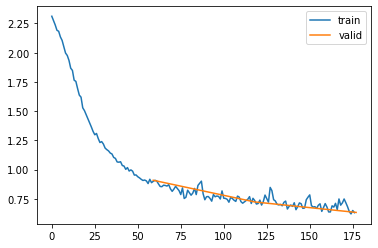

In [445]:
model = get_model()
metrics = MetricsCB(Accuracy=MulticlassAccuracy())
progress = ProgressCB(plot=True)
cbs = [TrainCB(), metrics, progress]
learn = Learner(model, dls=dls, cbs=cbs)
learn.fit(3)

In [474]:
class TrainLearner(Learner):
    def predict(self):
        self.preds = self.model(self.batch[0])
    
    def get_loss(self):
        self.loss = self.loss_func(self.preds, self.batch[1])
    
    def backward(self):
        self.loss.backward()
    
    def step(self):
        self.opt.step()
    
    def zero_grad(self):
        self.opt.zero_grad()

In [475]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls=(0,), lr=None, cbs=None, mom=0.85):
        self.mom = mom
        super().__init__(model, dls=dls, lr=lr, cbs=cbs)
    
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters():
                p.grad *= self.mom

Accuracy,loss,epoch,train
0.674,0.938,0,train
0.793,0.587,0,val
0.819,0.515,1,train
0.829,0.485,1,val


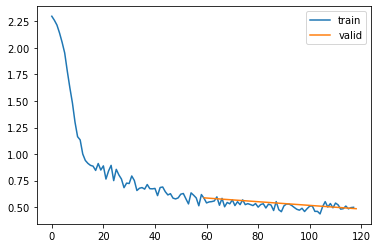

In [476]:
model = get_model()
metrics = MetricsCB(Accuracy=MulticlassAccuracy())
progress = ProgressCB(plot=True)
cbs = [metrics, progress]
learn = MomentumLearner(model, dls=dls, cbs=cbs, lr=0.1)
learn.fit(2)